# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


## Run GMA

In [2]:
!python ./graphMatching/main.py

Traceback (most recent call last):
  File "/Users/I538952/Desktop/master/4-semester-thesis/dataset-extension-attack/./graphMatching/main.py", line 21, in <module>
    from encoders.pst_encoder import PSTEncoder
  File "/Users/I538952/Desktop/master/4-semester-thesis/dataset-extension-attack/graphMatching/encoders/pst_encoder.py", line 5, in <module>
    import galois
ModuleNotFoundError: No module named 'galois'


## Define Dataset

In [2]:
class BloomFilterDataset(Dataset):
    def __init__(self, data_dir, isLabeled=False, all_two_grams=None):
        self.isLabeled = isLabeled
        self.allTwoGrams = all_two_grams
        self.data = pd.read_csv(data_dir, sep='\t')  # Load TSV data
        if self.isLabeled:
            # For reidentified data, extract labels (2-grams) from names
            self.data['label'] = self.data.apply(lambda row: self.extract_two_grams(row['surname'], row['firstname']), axis=1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        bloom_filter = self.data.iloc[idx]['bloomfilter']
        bloom_filter_tensor = self.bloomfilter_to_tensor(bloom_filter)

        if self.isLabeled:
            label = self.data.iloc[idx]['label']
            label_tensor = self.label_to_tensor(label)
            return bloom_filter_tensor, label_tensor
        else:
            # For unlabeled data (not_reidentified_individuals.tsv), just return the Bloom Filter
            return bloom_filter_tensor
    
    def extract_two_grams(self, surname, firstname):
        full_name = f"{surname} {firstname}".replace('"', '').replace('.', '').replace('/', '').strip()
        full_name = full_name.lower()  # Normalize to lowercase for consistency
        return [full_name[i:i+2] for i in range(len(full_name)-1) if ' ' not in full_name[i:i+2]]
    
    def bloomfilter_to_tensor(self, bloom_filter_str):
        bloom_filter_array = np.array([int(bit) for bit in bloom_filter_str], dtype=np.float32)
        return torch.tensor(bloom_filter_array)
    
    def label_to_tensor(self, label_two_grams):
        label_vector = np.zeros(len(self.allTwoGrams), dtype=np.float32)
        
        # Set 1 for the 2-grams present in the name
        for gram in label_two_grams:
            if gram in self.allTwoGrams:
                index = self.allTwoGrams.index(gram)
                label_vector[index] = 1
        
        return torch.tensor(label_vector)

## Create Datasets 

In [3]:
#Generate all 2-grams
alphabet = string.ascii_lowercase
all_two_grams = []
for a in alphabet:
    for b in alphabet:
        all_two_grams.append(a+b)
# Get a dictionary associating each 2-gram with an index
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}
# Create Datasets
data_labeled = BloomFilterDataset('./data/eves_information/reidentified_individuals.tsv', isLabeled=True, all_two_grams=all_two_grams)
data_not_labeled = BloomFilterDataset('./data/eves_information/not_reidentified_individuals.tsv', isLabeled=False, all_two_grams=all_two_grams)
bloomfilter_length = len(data_labeled[0][0])

## Create Dataloader

In [4]:
# Split proportions
train_size = int(0.8 * len(data_labeled))  # 80% training
val_size = len(data_labeled) - train_size  # 20% validation

# Split dataset
data_train, data_val = random_split(data_labeled, [train_size, val_size])
dataloader_train = DataLoader(data_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=16, shuffle=True)
dataloader_test = DataLoader(data_not_labeled, batch_size=16, shuffle=False)

## Pytorch Model

In [5]:
class BloomFilterToTwoGramClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_two_grams=676):
        super(BloomFilterToTwoGramClassifier, self).__init__()
        
        # Define the layers for multi-label classification of 2-grams
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input => first hidden layer
            nn.ReLU(),                       
            nn.Dropout(0.1),                  
            nn.Linear(hidden_dim, hidden_dim),  # First hidden layer => second hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_two_grams), # Second hidden layer => output layer
            nn.Sigmoid()                       
        )

    def forward(self, x):
        # Forward pass through the model
        output = self.model(x)
        return output

In [6]:
model = BloomFilterToTwoGramClassifier(input_dim=bloomfilter_length)

## Training Loop

In [7]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Number of epochs
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for bloom_filters, labels in tqdm(dataloader_train, desc="Training loop"):
        # Move data to device
        bloom_filters, labels = bloom_filters.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(bloom_filters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader_train.dataset)
    train_losses.append(train_loss)

    #Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for bloom_filters, labels in tqdm(dataloader_val, desc="Validation loop"):
            # Move data to device
            bloom_filters, labels = bloom_filters.to(device), labels.to(device)
            
            outputs = model(bloom_filters)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(dataloader_val.dataset)
        val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Training loop:   0%|          | 0/14 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.8300, Validation loss: 0.6932


Training loop:   0%|          | 0/14 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.6929, Validation loss: 0.6930


Training loop:   0%|          | 0/14 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.6928, Validation loss: 0.6930


Training loop:   0%|          | 0/14 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.6928, Validation loss: 0.6930


Training loop:   0%|          | 0/14 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.6928, Validation loss: 0.6930


## Visualize Losses

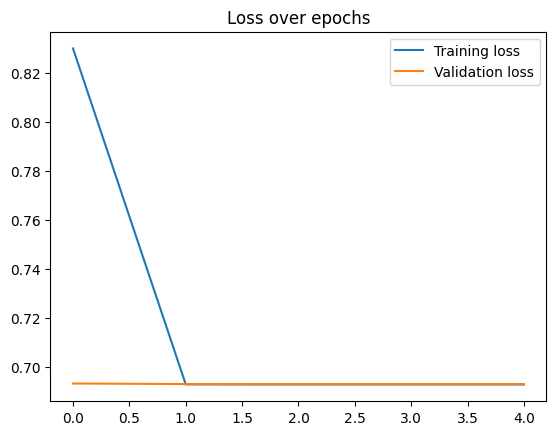

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Testing Area

In [18]:
# First entry for reference (labeled data):
# surname                                                  Hegarty
# firstname                                    Miss. Hanora "Nora"
# bloomfilter    0000000010100011000100000101000000000000100000001000000000100111011000001001100100000100000000001000000000000000001000100000000000010010000000000000100010001110110111000000000000100000000100000001010000000000100101000011000010001010000001000000000000000000001000011010011001000100000011100100000000000011000100100000110011000000000010000000000010000000000000110000000110000000000010000000011100000001000000100000001100101011001000000000010000001000000000001000010110110000000001001000100001010111010000000010000000111000000000010010110000000000001000000101010001000000001000001000010000100110000111001110000000001010011110000100000000000100000001100001100000000000010000000000000000000000100000000010000001000000000011100000000000001000101000010100001001000011000000000010001100000000100000001000001000000000100000101000000000000000000010000000100000000100001000000100000000000000011100000001001000000001100010000001000001000000000000010100100000000110101110010000010000010100000000011000001000000001110000101001000010101111
# uid                                                          654
# Name: 0, dtype: object
#print('Length Labeled data:', len(data_labeled))
#print('Length Unlabeled data:', len(data_not_labeled))

#bloomfilter_tensor, label_tensor = data_labeled[0]

#print('Bloom Filter Tensor:', bloomfilter_tensor)
#print('Bloom Filter Tensor Shape:', bloomfilter_tensor.shape)
#print('Label Tensor:', label_tensor)
#print('Label Tensor Shape:', label_tensor.shape)

#for bloomfilter_tensors, label_tensors in dataloader_train:
#    print('Bloom Filter Tensor Shape:', bloomfilter_tensors.shape)
#    print('Label Tensor Shape:', label_tensors.shape)
#    print(label_tensors)
#    break

#print(str(model)[:500])
#example_bloom, example_label = data_train[0]
#example_out = model(example_bloom)
#print(example_out.shape) 
#loss_function_applied = criterion(example_out, example_label)
#print(loss_function_applied)
#print(example_out)
 
# Apply model
bloomfilter_tensor = data_not_labeled[0]
result = model(bloomfilter_tensor)
# Result = Tensor of shape 676 with prob. for each 2gram
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(result)}

threshold = 0.000000001
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
filtered_two_gram_scores

{'be': 1.7385378692225117e-09,
 'hq': 1.0494203284139303e-09,
 'jw': 1.0889458224028203e-09,
 'mr': 1.0,
 'ro': 1.5398421426837672e-09,
 'tc': 2.3718302877284714e-09,
 'wx': 1.319601206084542e-09,
 'zg': 1.0454407339821614e-09}